# KEY_HAR_DOC_profiles.ipynb

## Profiles of Harding and Keystone Coves on 05-17 and 05-18 and comparing these to Dock measurements

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show


In [2]:
total_df = pd.read_csv('../data/total_df.csv')

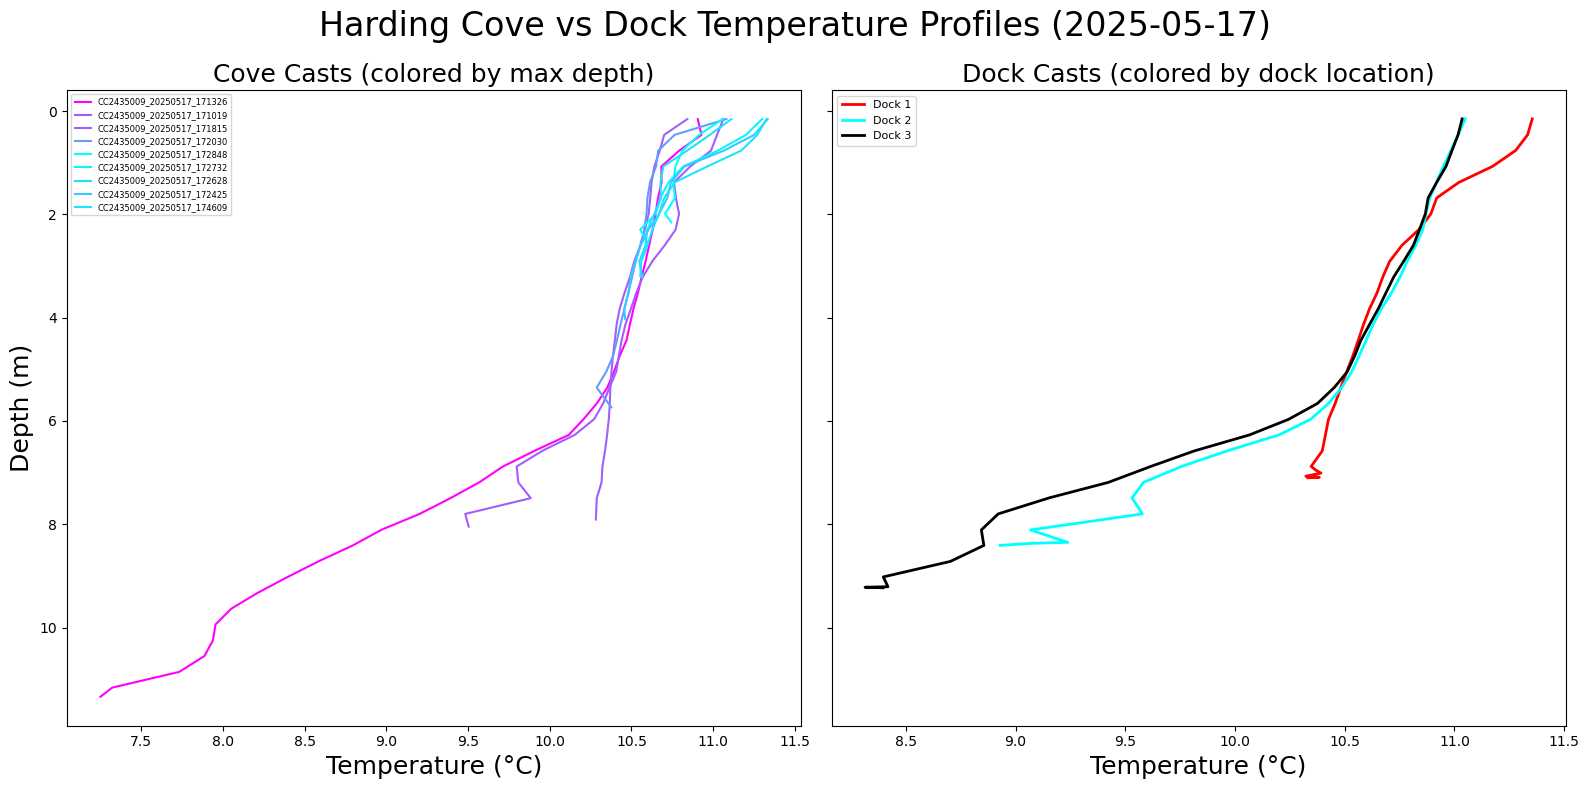

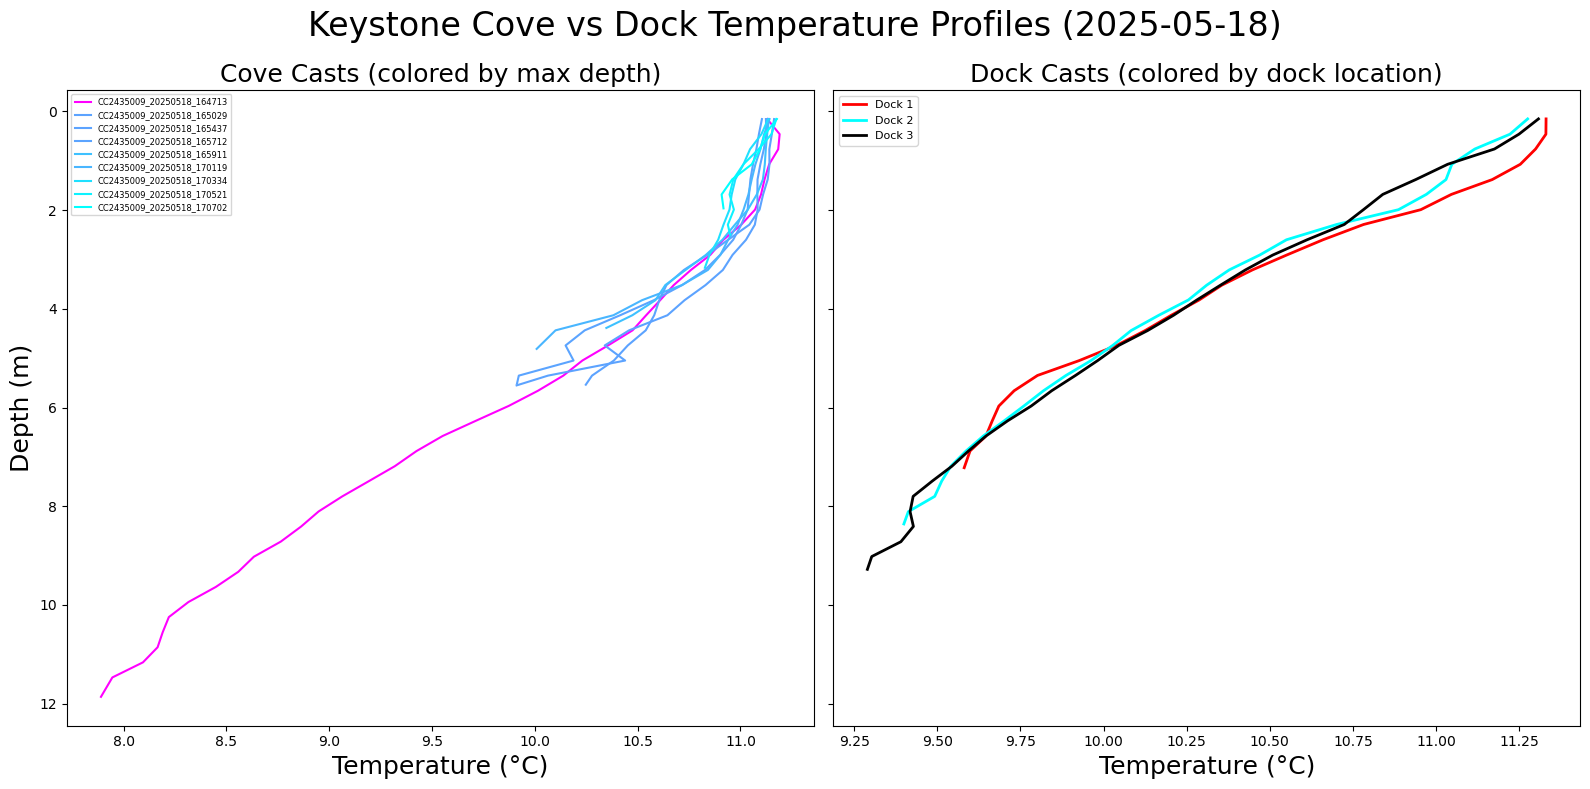

In [3]:
# time for some temperature profiles

# Harding file names for cove casts and dock casts 
harding_fnames = ['CC2435009_20250517_171326', 'CC2435009_20250517_171019', 'CC2435009_20250517_171815', 'CC2435009_20250517_172030', 
                  'CC2435009_20250517_172848', 'CC2435009_20250517_172732', 'CC2435009_20250517_172628', 'CC2435009_20250517_172425', 
                  'CC2435009_20250517_174609']
harding_dock1 = ['CC2435009_20250517_175733', 'CC2435009_20250517_175849', 'CC2435009_20250517_175943', 'CC2435009_20250517_180034', 'CC2435009_20250517_180205', 'CC2435009_20250517_180242']

harding_dock2 = ['CC2435009_20250517_180414', 'CC2435009_20250517_180453', 'CC2435009_20250517_180530']

harding_dock3 = ['CC2435009_20250517_180717', 'CC2435009_20250517_180756', 'CC2435009_20250517_180836']

# Keystone file names for cove casts and dock casts 
keystone_fnames = ['CC2435009_20250518_164713', 'CC2435009_20250518_165029', 'CC2435009_20250518_165437', 'CC2435009_20250518_165712',
                   'CC2435009_20250518_165911', 'CC2435009_20250518_170119', 'CC2435009_20250518_170334', 'CC2435009_20250518_170521',
                   'CC2435009_20250518_170702']
keystone_dock1 = ['CC2435009_20250518_183359']
keystone_dock2 = ['CC2435009_20250518_184039']
keystone_dock3 = ['CC2435009_20250518_184557']

import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_temperature_profiles(cove_files, dock_dict, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    fig.suptitle(title, fontsize=24)

    # --- Cove Casts: colored by max depth ---
    cmap = cm.cool
    depths = []

    for fname in cove_files:
        cast = total_df[total_df['File Name'] == fname].sort_values('Depth (m)')
        max_depth = cast['Depth (m)'].max()
        depths.append(max_depth)

    norm = mcolors.Normalize(vmin=min(depths), vmax=max(depths))

    for fname in cove_files:
        cast = total_df[total_df['File Name'] == fname].sort_values('Depth (m)', ascending=False)
        max_depth = cast['Depth (m)'].max()
        color = cmap(norm(max_depth))
        axs[0].plot(cast['Temperature (°C)'], cast['Depth (m)'], label=f"{fname}", color=color)

    
    axs[0].set_title('Cove Casts (colored by max depth)', fontsize=18)
    axs[0].set_xlabel('Temperature (°C)', fontsize=18)
    axs[0].set_ylabel('Depth (m)', fontsize=18)
    axs[0].invert_yaxis()
    axs[0].legend(fontsize=6)

    # --- Dock Casts: colored by location ---
    dock_colors = {
        'Dock 1': 'red',
        'Dock 2': 'cyan',
        'Dock 3': 'black'
    }

    for dock_label, file_list in dock_dict.items():
        # Combine all casts for this dock
        dock_df = total_df[total_df['File Name'].isin(file_list)].copy()
    
        # Round or bin depth to a standard set (if needed)
        dock_df['Depth (m)'] = dock_df['Depth (m)'].round(2)  # You can bin instead if needed
    
        # Group by depth and average
        avg_cast = dock_df.groupby('Depth (m)', as_index=False)['Temperature (°C)'].mean()
        avg_cast = avg_cast.sort_values('Depth (m)')

        # Plot averaged profile
        axs[1].plot(
            avg_cast['Temperature (°C)'], avg_cast['Depth (m)'],
            label=dock_label,
            color=dock_colors[dock_label],
            linewidth=2)

    
    axs[1].set_title('Dock Casts (colored by dock location)', fontsize=18)
    axs[1].set_xlabel('Temperature (°C)', fontsize=18)
    #axs[1].invert_yaxis()
    axs[1].legend(fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Create dock dicts
harding_dock_dict = {
    'Dock 1': harding_dock1,
    'Dock 2': harding_dock2,
    'Dock 3': harding_dock3
}

keystone_dock_dict = {
    'Dock 1': keystone_dock1,
    'Dock 2': keystone_dock2,
    'Dock 3': keystone_dock3
}

# Plot
plot_temperature_profiles(harding_fnames, harding_dock_dict, 'Harding Cove vs Dock Temperature Profiles (2025-05-17)')
plot_temperature_profiles(keystone_fnames, keystone_dock_dict, 'Keystone Cove vs Dock Temperature Profiles (2025-05-18)')

## Plotting the locations of Keystone Cove, Harding Cove, and Dock measurements 
- Load in tif files made using QGIS
- Create GeoDataFrames for the measurement locations
- Plot measurements from the coves colored based on the maximum depth

In [4]:
# Assuming total_df has 'Latitude', 'Longitude', 'File Name', and maybe 'Cove' columns
# Filter for Harding Cove and Keystone Cove file names

harding_files = harding_fnames
keystone_files = keystone_fnames
dock_files = harding_dock1 + harding_dock2 + harding_dock3 

harding_points = total_df[total_df['File Name'].isin(harding_files)]
keystone_points = total_df[total_df['File Name'].isin(keystone_files)]
dock_points = total_df[total_df['File Name'].isin(dock_files)]

dock_gdf = gpd.GeoDataFrame(dock_points, 
                            geometry=gpd.points_from_xy(dock_points['Longitude'], dock_points['Latitude']),
                            crs='EPSG:4326')

# Create GeoDataFrames with geometry column
harding_gdf = gpd.GeoDataFrame(
    harding_points,
    geometry=gpd.points_from_xy(harding_points['Longitude'], harding_points['Latitude']),
    crs='EPSG:4326'  # WGS84 lat/lon
)

keystone_gdf = gpd.GeoDataFrame(
    keystone_points,
    geometry=gpd.points_from_xy(keystone_points['Longitude'], keystone_points['Latitude']),
    crs='EPSG:4326'
)


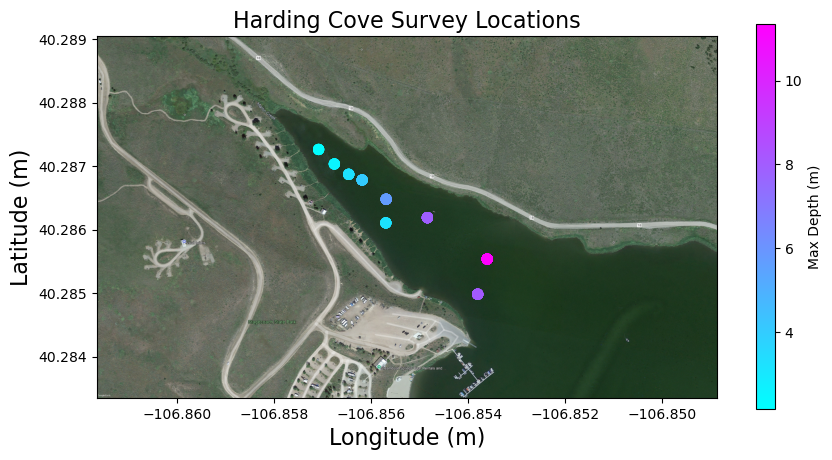

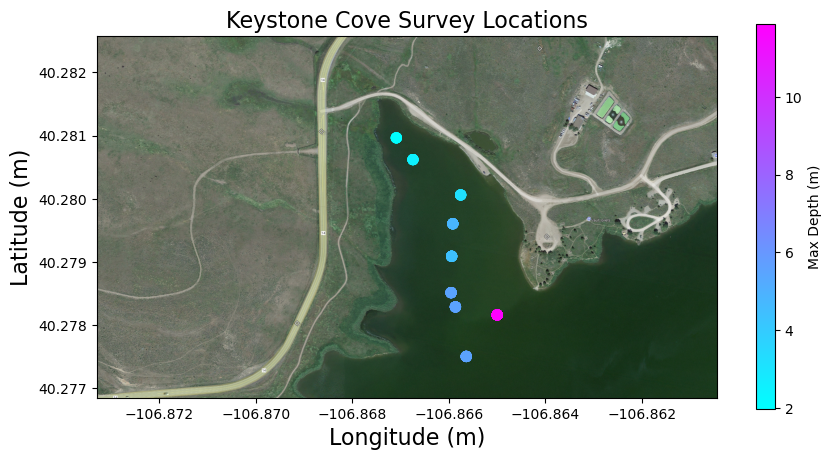

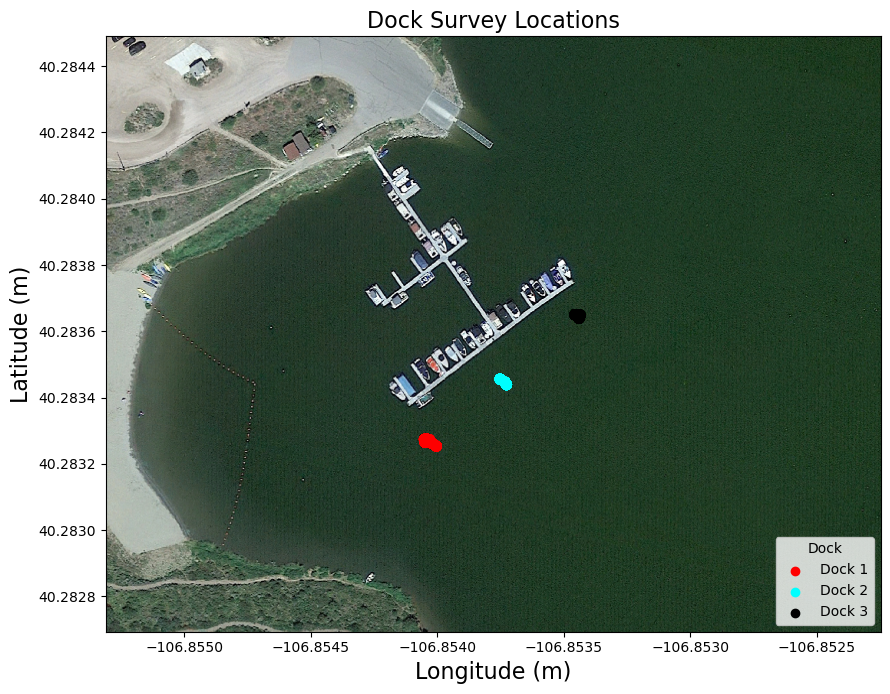

In [5]:
# Combine for lookup
dock1_files = set(harding_dock1)
dock2_files = set(keystone_dock2 + harding_dock2)
dock3_files = set(keystone_dock3 + harding_dock3)

dock_colors = {
    'Dock 1': 'red',
    'Dock 2': 'cyan',
    'Dock 3': 'black'
}


def assign_dock_label(file_name):
    if file_name in dock1_files:
        return 'Dock 1'
    elif file_name in dock2_files:
        return 'Dock 2'
    elif file_name in dock3_files:
        return 'Dock 3'
    else:
        return None

def plot_survey_on_raster(tif_path, gdf_points, title, zoom_bounds=None):
    is_dock = 'Dock' in title

    if is_dock:
        # Assign dock label and color
        gdf = gdf_points.copy()
        gdf['Dock'] = gdf['File Name'].apply(assign_dock_label)
        gdf['color'] = gdf['Dock'].map(dock_colors)
    else:
        # Depth-based coloring
        max_depths = (
            total_df.groupby('File Name')['Depth (m)']
            .max()
            .rename('Max Depth')
            .reset_index()
        )
        gdf = gdf_points.merge(max_depths, on='File Name', how='left').copy()
        cmap = cm.cool
        norm = mcolors.Normalize(vmin=gdf['Max Depth'].min(), vmax=gdf['Max Depth'].max())
        gdf['color'] = gdf['Max Depth'].apply(lambda d: cmap(norm(d)))

    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax)

        # Reproject if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Plot
        gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=50, alpha=0.7)

        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Longitude (m)', fontsize=16)
        ax.set_ylabel('Latitude (m)', fontsize=16)
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
        ax.ticklabel_format(style='plain', axis='both')

        if zoom_bounds:
            ax.set_xlim([zoom_bounds[0], zoom_bounds[2]])
            ax.set_ylim([zoom_bounds[1], zoom_bounds[3]])

        if not is_dock:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, ax=ax, label='Max Depth (m)', shrink=0.5)
        else:
            # Optional: add legend
            for dock, color in dock_colors.items():
                ax.scatter([], [], color=color, label=dock)
            ax.legend(title='Dock', loc='lower right')

        plt.show()

# Call the function for each cove
plot_survey_on_raster("../data/tifs/2good harding cove_modified.tif", harding_gdf, "Harding Cove Survey Locations")
plot_survey_on_raster("../data/tifs/Keystonetif.tif", keystone_gdf, "Keystone Cove Survey Locations")
#plot_survey_on_raster('../data/tifs/docktif.tif', dock_gdf, 'Dock Survey Locations')

dock_bounds = dock_gdf.total_bounds
padding = 0.0007
xmin, ymin, xmax, ymax = dock_bounds
zoom_bounds = [xmin - 1.8*padding, ymin - 0.8*padding, xmax + 1.7*padding, ymax + 1.2*padding]

plot_survey_on_raster('../data/tifs/docktif.tif', dock_gdf, 'Dock Survey Locations', zoom_bounds=zoom_bounds)
